# researchers

INDEX

In [52]:
# Libraries
import pandas as pd

# Abstract Syntax Trees
import ast

# API tools
import requests

# progress bar
from tqdm.notebook import tqdm

# Multiprocessing
from joblib import Parallel, delayed, effective_n_jobs

# Functions
import sys
sys.path.append('../src')
from support_clean import *

### Import researchers_df

In [2]:
researchers = pd.read_csv('../data/researchers_df.csv')
researchers.head(2)

,Unnamed: 0,pub_id,authors,journal_id,first_auth,last_auth,auth_aff_list,first_auth_aff,last_auth_aff
0,0,38012702,"['Wu, Anbiao', 'Zhang, Jiyan']",101222974.0,"Wu, Anbiao","Zhang, Jiyan","['Beijing Institute of Basic Medical Sciences,...","Beijing Institute of Basic Medical Sciences, B...","Beijing Institute of Basic Medical Sciences, B..."
1,1,38012669,"['Zheng, Shengnan', 'Li, Yiquan', 'Song, Xiaom...",101222974.0,"Zheng, Shengnan","Liu, Huiqing","['Department of Pharmacology, School of Basic ...","Department of Pharmacology, School of Basic Me...","Department of Rehabilitation Medicine, The Sec..."


## Data Cleansing

In [3]:
df = researchers.copy()

In [4]:
to_drop = ['Unnamed: 0']
display(df.shape)
df = df.drop(columns=to_drop)
display(df.shape)

(61981, 9)

(61981, 8)

In [5]:
df = df.rename(columns={'ID': 'pub_id'})
df.head(2)

,pub_id,authors,journal_id,first_auth,last_auth,auth_aff_list,first_auth_aff,last_auth_aff
0,38012702,"['Wu, Anbiao', 'Zhang, Jiyan']",101222974.0,"Wu, Anbiao","Zhang, Jiyan","['Beijing Institute of Basic Medical Sciences,...","Beijing Institute of Basic Medical Sciences, B...","Beijing Institute of Basic Medical Sciences, B..."
1,38012669,"['Zheng, Shengnan', 'Li, Yiquan', 'Song, Xiaom...",101222974.0,"Zheng, Shengnan","Liu, Huiqing","['Department of Pharmacology, School of Basic ...","Department of Pharmacology, School of Basic Me...","Department of Rehabilitation Medicine, The Sec..."


### Create a df of researchers

In [6]:
# Transform the strings to lists again
df['authors'] = df['authors'].apply(ast.literal_eval)
df_authors = df.explode('authors')

In [7]:
df_authors[:5]

,pub_id,authors,journal_id,first_auth,last_auth,auth_aff_list,first_auth_aff,last_auth_aff
0,38012702,"Wu, Anbiao",101222974.0,"Wu, Anbiao","Zhang, Jiyan","['Beijing Institute of Basic Medical Sciences,...","Beijing Institute of Basic Medical Sciences, B...","Beijing Institute of Basic Medical Sciences, B..."
0,38012702,"Zhang, Jiyan",101222974.0,"Wu, Anbiao","Zhang, Jiyan","['Beijing Institute of Basic Medical Sciences,...","Beijing Institute of Basic Medical Sciences, B...","Beijing Institute of Basic Medical Sciences, B..."
1,38012669,"Zheng, Shengnan",101222974.0,"Zheng, Shengnan","Liu, Huiqing","['Department of Pharmacology, School of Basic ...","Department of Pharmacology, School of Basic Me...","Department of Rehabilitation Medicine, The Sec..."
1,38012669,"Li, Yiquan",101222974.0,"Zheng, Shengnan","Liu, Huiqing","['Department of Pharmacology, School of Basic ...","Department of Pharmacology, School of Basic Me...","Department of Rehabilitation Medicine, The Sec..."
1,38012669,"Song, Xiaomeng",101222974.0,"Zheng, Shengnan","Liu, Huiqing","['Department of Pharmacology, School of Basic ...","Department of Pharmacology, School of Basic Me...","Department of Rehabilitation Medicine, The Sec..."


### Create the researchers ID: res_id

In [8]:
# Create a list with the unique researchers
researchers_list = df_authors['authors']
display(len(researchers_list))
researchers_list = list(set(researchers_list))
display(len(researchers_list))

372016

228898

In [11]:
# Transform to df
researchers_df = pd.DataFrame(researchers_list)

In [12]:
researchers_df = researchers_df.rename(columns={0: 'researcher'})

In [13]:
# Create a column with the surnames
researchers_df['surname'] = [row.split(',')[0] for row in researchers_df['researcher']]

In [14]:
# Create a column with the names
erratic_names = []

def name_column(x): 
    '''
    '''
    try:
        if ',' in x:
            name = x.split(',')[1]
            return name
        elif len(x.split(' ')) == 2:
            name = x.split(' ')[0]
            return name
        elif len(x.split(' ')) > 2:
            return ''
        else: 
            erratic_names.append(x)
            return x
    except:
        erratic_names.append(x)
        return x

In [15]:
researchers_df['name'] = researchers_df['researcher'].apply(name_column)

In [16]:
researchers_df.head()

,researcher,surname,name
0,"Zhang, Yihe",Zhang,Yihe
1,"El Achkar, Christelle M",El Achkar,Christelle M
2,"Fang, Yiyuan",Fang,Yiyuan
3,"Park, Dong Woo",Park,Dong Woo
4,"Cai, Weijia",Cai,Weijia


In [20]:
# Create res_id
researchers_df['res_id'] = researchers_df.index

In [24]:
researchers_df.head()

,researcher,surname,name,res_id
0,"Zhang, Yihe",Zhang,Yihe,0
1,"El Achkar, Christelle M",El Achkar,Christelle M,1
2,"Fang, Yiyuan",Fang,Yiyuan,2
3,"Park, Dong Woo",Park,Dong Woo,3
4,"Cai, Weijia",Cai,Weijia,4


In [27]:
# Change the order of the columns
researchers_df = researchers_df[['res_id', 'researcher', 'surname', 'name']]

### Consider identifying the gender of the author based on their name, recognizing that this method may not always accurately reflect personal gender identity. Exercise sensitivity and be aware of the potential for inaccuracies in the process

**genderize.io** is a free API, but limited at 1000 requests by day.

    url = f'https://api.genderize.io/?name[]={name}'   

**The answer will be like this:**

    { "name": "peter",
      "gender": "male",
      "probability": 0.99,
      "count": 165452 }

In [ ]:
error

In [29]:
names = researchers_df['name']

In [54]:
with open('../genderizer_api.txt', 'r') as file:
    genderized_api = file.read().strip()

In [55]:
# Create a list of urls
url_list = []

for name in names:
    
    if len(name.split(' ')) > 1:
        n = name.split(' ')[1]
    else:
        n = name
        
    url = f'https://api.genderize.io?name={n}&apikey={genderized_api}'
    url_list.append(url)

In [56]:
gender = []
gender_prob = []

def get_gender(url):
    '''
    '''
    res = requests.get(url)
    res_api = res.json()
    gender.append(res_api['gender'])
    gender_prob.append(res_api['probability'])
    return gender, gender_prob

In [57]:
print(f"Number of cores: {effective_n_jobs()}")

Number of cores: 8


In [60]:
parallel = Parallel(n_jobs = 4, verbose=False)
output = parallel(delayed(get_gender)(url) for url in tqdm(url_list[:8]))

  0%|          | 0/8 [00:00<?, ?it/s]

In [72]:
output_df = pd.DataFrame(output, columns=['gender', 'gender_prob'])

In [73]:
output_df

,gender,gender_prob
0,[male],[0.63]
1,[female],[0.99]
2,[male],[0.78]
3,[male],[0.99]
4,[female],[0.6]
5,[female],[1.0]
6,[male],[0.99]
7,[female],[1.0]


In [ ]:
researchers_df['gender'] = output_df['gender']
researchers_df['gender_prob'] = output_df['gender_prob']

In [ ]:
researchers_df.to_csv('../data/researchers_gender_db.csv')

### Create a list of affiliations

In [9]:
df['auth_aff_list'] = df['auth_aff_list'].fillna('[]')

In [10]:
df['auth_aff_list'] = df['auth_aff_list'].apply(ast.literal_eval)

In [12]:
df_affiliations = df.explode('auth_aff_list')

In [13]:
df_affiliations[:5]

,pub_id,authors,first_auth,last_auth,auth_aff_list,first_auth_aff,last_auth_aff
0,38012702,"[Wu, Anbiao, Zhang, Jiyan]","Wu, Anbiao","Zhang, Jiyan","Beijing Institute of Basic Medical Sciences, B...","Beijing Institute of Basic Medical Sciences, B...","Beijing Institute of Basic Medical Sciences, B..."
0,38012702,"[Wu, Anbiao, Zhang, Jiyan]","Wu, Anbiao","Zhang, Jiyan","Beijing Institute of Basic Medical Sciences, B...","Beijing Institute of Basic Medical Sciences, B...","Beijing Institute of Basic Medical Sciences, B..."
1,38012669,"[Zheng, Shengnan, Li, Yiquan, Song, Xiaomeng, ...","Zheng, Shengnan","Liu, Huiqing","Department of Pharmacology, School of Basic Me...","Department of Pharmacology, School of Basic Me...","Department of Rehabilitation Medicine, The Sec..."
1,38012669,"[Zheng, Shengnan, Li, Yiquan, Song, Xiaomeng, ...","Zheng, Shengnan","Liu, Huiqing","Department of Pharmacology, School of Basic Me...","Department of Pharmacology, School of Basic Me...","Department of Rehabilitation Medicine, The Sec..."
1,38012669,"[Zheng, Shengnan, Li, Yiquan, Song, Xiaomeng, ...","Zheng, Shengnan","Liu, Huiqing","Department of Pharmacology, School of Basic Me...","Department of Pharmacology, School of Basic Me...","Department of Rehabilitation Medicine, The Sec..."


In [12]:
# Create a list with all the researchers
researchers_list = []

for i,res in enumerate(df['authors']):
    j = 0
    while j < len(res):
        researchers_list.append(res[j])
        j += 1

372016

228898

In [14]:
res_df = pd.DataFrame(researchers_list)

In [15]:
res_df = res_df.rename(columns={0: 'res_name'})
res_df.head()

,res_name
0,"Terro, F"
1,"McCarter, Stuart J"
2,"Pflugrad, Henning"
3,"Skolnick, Brett"
4,"Lu, Jingmin"


In [17]:
display(res_df.shape)
res_df = pd.merge(res_df, df, left_on='res_name', right_on='last_auth', how='left')
display(res_df.shape)

(228898, 1)

(251823, 8)

In [19]:
display(res_df.shape)
res_df = pd.merge(res_df, df, left_on='res_name', right_on='first_auth', how='left')
display(res_df.shape)

(251823, 8)

(281620, 15)

In [21]:
res_df.head(2)

,res_name,pub_id_x,authors_x,first_auth_x,last_auth_x,auth_aff_list_x,first_auth_aff_x,last_auth_aff_x,pub_id_y,authors_y,first_auth_y,last_auth_y,auth_aff_list_y,first_auth_aff_y,last_auth_aff_y
0,"Terro, F",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"McCarter, Stuart J",NaN,NaN,NaN,NaN,NaN,NaN,NaN,27485946.0,"[McCarter, Stuart J, St Louis, Erik K, Boeve, ...","McCarter, Stuart J","Boeve, Bradley F","['Mayo Center for Sleep Medicine, Mayo Clinic ...","Mayo Center for Sleep Medicine, Mayo Clinic an...","Department of Neurology, Mayo Clinic and Found..."


### Fill nan and reduce the dimensions

In [23]:
cols_to_fill = ['pub_id_x', 
                'authors_x', 
                'first_auth_x', 
                'last_auth_x',
                'auth_aff_list_x', 
                'first_auth_aff_x', 
                'last_auth_aff_x']

for col in cols_to_fill:
    res_df[col].fillna(res_df[col.replace('_x', '_y')], inplace=True)

res_df.drop(columns=['pub_id_y', 'authors_y', 'first_auth_y', 'last_auth_y', 'auth_aff_list_y', 'first_auth_aff_y', 'last_auth_aff_y'], inplace=True)

In [24]:
for col in cols_to_fill:
    new_name = col.replace('_x', '')
    res_df.rename(columns={col: new_name}, inplace=True)

In [26]:
res_df.head(2)

,res_name,pub_id,authors,first_auth,last_auth,auth_aff_list,first_auth_aff,last_auth_aff
0,"Terro, F",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"McCarter, Stuart J",27485946.0,"[McCarter, Stuart J, St Louis, Erik K, Boeve, ...","McCarter, Stuart J","Boeve, Bradley F","['Mayo Center for Sleep Medicine, Mayo Clinic ...","Mayo Center for Sleep Medicine, Mayo Clinic an...","Department of Neurology, Mayo Clinic and Found..."


### Drop duplicates

In [29]:
display(res_df.shape)
res_df = res_df.drop_duplicates(subset=['res_name'])
display(res_df.shape)

(281620, 8)

(228898, 8)

### Find collabs

In [36]:
# SLOW CELL 
'''
res_df['collab'] = res_df['res_name'].apply(lambda name: [author for authors_list in df['authors'] for author in authors_list if name == author])
''';

In [35]:
res_df.head()

,res_name,pub_id,authors,first_auth,last_auth,auth_aff_list,first_auth_aff,last_auth_aff,collab
0,"Terro, F",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Terro, F]"
1,"McCarter, Stuart J",27485946.0,"[McCarter, Stuart J, St Louis, Erik K, Boeve, ...","McCarter, Stuart J","Boeve, Bradley F","['Mayo Center for Sleep Medicine, Mayo Clinic ...","Mayo Center for Sleep Medicine, Mayo Clinic an...","Department of Neurology, Mayo Clinic and Found...","[McCarter, Stuart J, McCarter, Stuart J]"
3,"Pflugrad, Henning",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Pflugrad, Henning]"
4,"Skolnick, Brett",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Skolnick, Brett]"
5,"Lu, Jingmin",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Lu, Jingmin]"


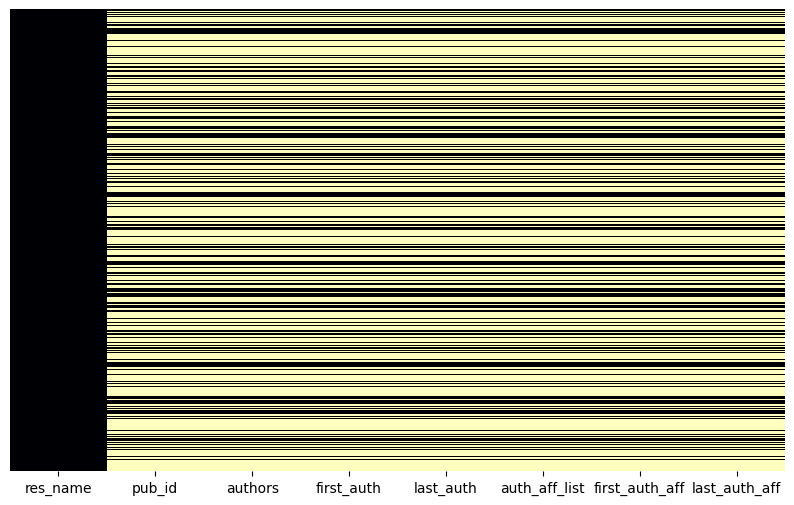

In [31]:
view_nan(res_df)

In [ ]:
res_df.to_csv('../data/res_db.csv')